In [1]:
from tensorflow.keras.utils import get_file
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
import numpy as np
import tarfile
from nltk import FreqDist
from functools import reduce
import os
import re

In [6]:
DATA_DIR = os.getenv("HOME") + '/aiffel/babi_memory_net/e-28-korean/'
TRAIN_FILE = os.path.join(DATA_DIR, "qa1_single-supporting-fact_train_kor.txt")
TEST_FILE = os.path.join(DATA_DIR, "qa1_single-supporting-fact_test_kor.txt")

In [7]:
i = 0
lines = open(TRAIN_FILE , "rb")
for line in lines:
    line = line.decode("utf-8").strip()
    # lno, text = line.split(" ", 1) # ID와 TEXT 분리
    i = i + 1
    print(line)
    if i == 20:
        break

1 필웅이는 화장실로 갔습니다.
2 은경이는 복도로 이동했습니다.
3 필웅이는 어디야? 	화장실	1
4 수종이는 복도로 복귀했습니다.
5 경임이는 정원으로 갔습니다.
6 수종이는 어디야? 	복도	4
7 은경이는 사무실로 갔습니다.
8 경임이는 화장실로 뛰어갔습니다.
9 수종이는 어디야? 	복도	4
10 필웅이는 복도로 갔습니다.
11 수종이는 사무실로 가버렸습니다.
12 수종이는 어디야? 	사무실	11
13 은경이는 정원으로 복귀했습니다.
14 은경이는 침실로 갔습니다.
15 경임이는 어디야? 	화장실	8
1 경임이는 사무실로 가버렸습니다.
2 경임이는 화장실로 이동했습니다.
3 경임이는 어디야? 	화장실	2
4 필웅이는 침실로 이동했습니다.
5 수종이는 복도로 갔습니다.


### 전처리

In [8]:
def read_data(dir):
    stories, questions, answers = [], [], [] # 각각 스토리, 질문, 답변을 저장할 예정
    story_temp = [] # 현재 시점의 스토리 임시 저장
    lines = open(dir, "rb")

    for line in lines:
        line = line.decode("utf-8") # b' 제거
        line = line.strip() # '\n' 제거
        idx, text = line.split(" ", 1) # 맨 앞에 있는 id number 분리
        # 여기까지는 모든 줄에 적용되는 전처리

        if int(idx) == 1:
            story_temp = []
        
        if "\t" in text: # 현재 읽는 줄이 질문 (tab) 답변 (tab)인 경우
            question, answer, _ = text.split("\t") # 질문과 답변을 각각 저장
            stories.append([x for x in story_temp if x]) # 지금까지의 누적 스토리를 스토리에 저장
            questions.append(question)
            answers.append(answer)

        else: # 현재 읽는 줄이 스토리인 경우
            story_temp.append(text) # 임시 저장

    lines.close()
    return stories, questions, answers

In [9]:
train_data = read_data(TRAIN_FILE)
test_data = read_data(TEST_FILE)

In [21]:
train_data[0]

[['필웅이는 화장실로 갔습니다.', '은경이는 복도로 이동했습니다.'],
 ['필웅이는 화장실로 갔습니다.',
  '은경이는 복도로 이동했습니다.',
  '수종이는 복도로 복귀했습니다.',
  '경임이는 정원으로 갔습니다.'],
 ['필웅이는 화장실로 갔습니다.',
  '은경이는 복도로 이동했습니다.',
  '수종이는 복도로 복귀했습니다.',
  '경임이는 정원으로 갔습니다.',
  '은경이는 사무실로 갔습니다.',
  '경임이는 화장실로 뛰어갔습니다.'],
 ['필웅이는 화장실로 갔습니다.',
  '은경이는 복도로 이동했습니다.',
  '수종이는 복도로 복귀했습니다.',
  '경임이는 정원으로 갔습니다.',
  '은경이는 사무실로 갔습니다.',
  '경임이는 화장실로 뛰어갔습니다.',
  '필웅이는 복도로 갔습니다.',
  '수종이는 사무실로 가버렸습니다.'],
 ['필웅이는 화장실로 갔습니다.',
  '은경이는 복도로 이동했습니다.',
  '수종이는 복도로 복귀했습니다.',
  '경임이는 정원으로 갔습니다.',
  '은경이는 사무실로 갔습니다.',
  '경임이는 화장실로 뛰어갔습니다.',
  '필웅이는 복도로 갔습니다.',
  '수종이는 사무실로 가버렸습니다.',
  '은경이는 정원으로 복귀했습니다.',
  '은경이는 침실로 갔습니다.'],
 ['경임이는 사무실로 가버렸습니다.', '경임이는 화장실로 이동했습니다.'],
 ['경임이는 사무실로 가버렸습니다.',
  '경임이는 화장실로 이동했습니다.',
  '필웅이는 침실로 이동했습니다.',
  '수종이는 복도로 갔습니다.'],
 ['경임이는 사무실로 가버렸습니다.',
  '경임이는 화장실로 이동했습니다.',
  '필웅이는 침실로 이동했습니다.',
  '수종이는 복도로 갔습니다.',
  '은경이는 정원으로 이동했습니다.',
  '은경이는 사무실로 가버렸습니다.'],
 ['경임이는 사무실로 가버렸습니다.',
  '경임이는 화장실로 이동했습니다.',
  '필웅이는 침실로 이동했습니다.',
  '수종이는 복도로 

In [12]:
train_stories, train_questions, train_answers = read_data(TRAIN_FILE)
test_stories, test_questions, test_answers = read_data(TEST_FILE)

In [18]:
train_stories[0]

['필웅이는 화장실로 갔습니다.', '은경이는 복도로 이동했습니다.']

In [19]:
train_questions[0]

'필웅이는 어디야? '

In [20]:
train_answers[0]

'화장실'

In [22]:
print(len(train_stories))
print(len(train_questions))
print(len(train_answers))
print(len(test_stories))
print(len(test_questions))
print(len(test_answers))

10000
10000
10000
1000
1000
1000


In [25]:
def tokenize(sent):
    return [ x.strip() for x in re.sub(r"\s+|\b", '\f', sent).split('\f') if x.strip() ] # python 3.7의 경우 

In [26]:
def preprocess_data(train_data, test_data):
    counter = FreqDist()
    
    # 두 문장의 story를 하나의 문장으로 통합하는 함수
    flatten = lambda data: reduce(lambda x, y: x + y, data)

    # 각 샘플의 길이를 저장하는 리스트
    story_len = []
    question_len = []
    
    for stories, questions, answers in [train_data, test_data]:
        for story in stories:
            stories = tokenize(flatten(story)) # 스토리의 문장들을 펼친 후 토큰화
            story_len.append(len(stories)) # 각 story의 길이 저장
            for word in stories: # 단어 집합에 단어 추가
                counter[word] += 1
        for question in questions:
            question = tokenize(question)
            question_len.append(len(question))
            for word in question:
                counter[word] += 1
        for answer in answers:
            answer = tokenize(answer)
            for word in answer:
                counter[word] += 1

    # 단어장 생성
    word2idx = {word : (idx + 1) for idx, (word, _) in enumerate(counter.most_common())}
    idx2word = {idx : word for word, idx in word2idx.items()}

    # 가장 긴 샘플의 길이
    story_max_len = np.max(story_len)
    question_max_len = np.max(question_len)

    return word2idx, idx2word, story_max_len, question_max_len

In [27]:
word2idx, idx2word, story_max_len, question_max_len = preprocess_data(train_data, test_data)

In [28]:
print(word2idx)

{'.': 1, '경임이는': 2, '은경이는': 3, '수종이는': 4, '필웅이는': 5, '이동했습니다': 6, '가버렸습니다': 7, '뛰어갔습니다': 8, '복귀했습니다': 9, '갔습니다': 10, '화장실로': 11, '정원으로': 12, '복도로': 13, '어디야': 14, '?': 15, '부엌으로': 16, '사무실로': 17, '침실로': 18, '화장실': 19, '정원': 20, '사무실': 21, '침실': 22, '복도': 23, '부엌': 24}


In [29]:
vocab_size = len(word2idx) + 1

In [30]:
print('스토리의 최대 길이 :',story_max_len)
print('질문의 최대 길이 :',question_max_len)

스토리의 최대 길이 : 40
질문의 최대 길이 : 3


In [31]:
def vectorize(data, word2idx, story_maxlen, question_maxlen):
    Xs, Xq, Y = [], [], []
    flatten = lambda data: reduce(lambda x, y: x + y, data)

    stories, questions, answers = data
    for story, question, answer in zip(stories, questions, answers):
        xs = [word2idx[w] for w in tokenize(flatten(story))]
        xq = [word2idx[w] for w in tokenize(question)]
        Xs.append(xs)
        Xq.append(xq)
        Y.append(word2idx[answer])

    # 스토리와 질문은 각각의 최대 길이로 패딩
    # 정답은 원-핫 인코딩
    return pad_sequences(Xs, maxlen=story_maxlen),\
           pad_sequences(Xq, maxlen=question_maxlen),\
           to_categorical(Y, num_classes=len(word2idx) + 1)

In [32]:
Xstrain, Xqtrain, Ytrain = vectorize(train_data, word2idx, story_max_len, question_max_len)
Xstest, Xqtest, Ytest = vectorize(test_data, word2idx, story_max_len, question_max_len)

In [33]:
print(Xstrain.shape, Xqtrain.shape, Ytrain.shape, Xstest.shape, Xqtest.shape, Ytest.shape)

(10000, 40) (10000, 3) (10000, 25) (1000, 40) (1000, 3) (1000, 25)


In [34]:
Xstrain[0]

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  5, 11,
       10,  1,  3, 13,  6,  1], dtype=int32)

In [36]:
Xqtrain[0]

array([ 5, 14, 15], dtype=int32)

In [37]:
Ytrain[0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0.], dtype=float32)

# 메모리 네트워크 구축하기

In [38]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Permute, dot, add, concatenate
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input, Activation
import matplotlib.pyplot as plt

In [39]:
# 에포크 횟수
train_epochs = 120
# 배치 크기
batch_size = 32
# 임베딩 크기
embed_size = 50
# LSTM의 크기
lstm_size = 64
# 과적합 방지 기법인 드롭아웃 적용 비율
dropout_rate = 0.30

In [40]:
input_sequence = Input((story_max_len,))
question = Input((question_max_len,))
 
print('Stories :', input_sequence)
print('Question:', question)

Stories : Tensor("input_1:0", shape=(None, 40), dtype=float32)
Question: Tensor("input_2:0", shape=(None, 3), dtype=float32)


In [41]:
# 스토리를 위한 첫번째 임베딩. 그림에서의 Embedding A
input_encoder_m = Sequential()
input_encoder_m.add(Embedding(input_dim=vocab_size,
                              output_dim=embed_size))
input_encoder_m.add(Dropout(dropout_rate))
# 결과 : (samples, story_max_len, embed_size) / 샘플의 수, 문장의 최대 길이, 임베딩 벡터의 차원
 
# 스토리를 위한 두번째 임베딩. 그림에서의 Embedding C
# 임베딩 벡터의 차원을 question_max_len(질문의 최대 길이)로 한다.
input_encoder_c = Sequential()
input_encoder_c.add(Embedding(input_dim=vocab_size,
                              output_dim=question_max_len))
input_encoder_c.add(Dropout(dropout_rate))
# 결과 : (samples, story_max_len, question_max_len) / 샘플의 수, 문장의 최대 길이, 질문의 최대 길이(임베딩 벡터의 차원)

In [42]:
# 질문을 위한 임베딩. 그림에서의 Embedding B
question_encoder = Sequential()
question_encoder.add(Embedding(input_dim=vocab_size,
                               output_dim=embed_size,
                               input_length=question_max_len))
question_encoder.add(Dropout(dropout_rate))
# 결과 : (samples, question_max_len, embed_size) / 샘플의 수, 질문의 최대 길이, 임베딩 벡터의 차원

In [43]:
# 실질적인 임베딩 과정
input_encoded_m = input_encoder_m(input_sequence)
input_encoded_c = input_encoder_c(input_sequence)
question_encoded = question_encoder(question)

print('Input encoded m', input_encoded_m)
print('Input encoded c', input_encoded_c)
print('Question encoded', question_encoded)

Input encoded m Tensor("sequential/Identity:0", shape=(None, 40, 50), dtype=float32)
Input encoded c Tensor("sequential_1/Identity:0", shape=(None, 40, 3), dtype=float32)
Question encoded Tensor("sequential_2/Identity:0", shape=(None, 3, 50), dtype=float32)


In [44]:
# 스토리 단어들과 질문 단어들 간의 유사도를 구하는 과정
# 유사도는 내적을 사용한다.
match = dot([input_encoded_m, question_encoded], axes=-1, normalize=False)
match = Activation('softmax')(match)
print('Match shape', match)
# 결과 : (samples, story_max_len, question_max_len) / 샘플의 수, 문장의 최대 길이, 질문의 최대 길이

Match shape Tensor("activation/Identity:0", shape=(None, 40, 3), dtype=float32)


In [45]:
# 매칭 유사도 행렬과 질문에 대한 임베딩을 더한다.
response = add([match, input_encoded_c])  # (samples, story_maxlen, question_max_len)
response = Permute((2, 1))(response)  # (samples, question_max_len, story_maxlen)
print('Response shape', response)

Response shape Tensor("permute/Identity:0", shape=(None, 3, 40), dtype=float32)


In [46]:
# concatenate the response vector with the question vector sequence
answer = concatenate([response, question_encoded])
print('Answer shape', answer)
 
answer = LSTM(lstm_size)(answer)  # Generate tensors of shape 32
answer = Dropout(dropout_rate)(answer)
answer = Dense(vocab_size)(answer)  # (samples, vocab_size)
# we output a probability distribution over the vocabulary
answer = Activation('softmax')(answer)

Answer shape Tensor("concatenate/Identity:0", shape=(None, 3, 90), dtype=float32)


In [47]:
import os

# 모델 컴파일
model = Model([input_sequence, question], answer)
model.compile(optimizer='rmsprop', loss='categorical_crossentropy',
              metrics=['acc'])
 
# 테스트 데이터를 검증 데이터로 사용하면서 모델 훈련 시작
history = model.fit([Xstrain, Xqtrain],
         Ytrain, batch_size, train_epochs,
         validation_data=([Xstest, Xqtest], Ytest))
 
# 훈련 후에는 모델 저장
model_path = os.getenv('HOME')+'/aiffel/babi_memory_net/model.h5'
model.save(model_path)

Epoch 1/120
313/313 [==============================] - 1s 3ms/step - loss: 1.9149 - acc: 0.1697 - val_loss: 1.7829 - val_acc: 0.1590
Epoch 2/120
313/313 [==============================] - 1s 3ms/step - loss: 1.6902 - acc: 0.2877 - val_loss: 1.5474 - val_acc: 0.3850
Epoch 3/120
313/313 [==============================] - 1s 2ms/step - loss: 1.5394 - acc: 0.3753 - val_loss: 1.4759 - val_acc: 0.3920
Epoch 4/120
313/313 [==============================] - 1s 2ms/step - loss: 1.4965 - acc: 0.4094 - val_loss: 1.4548 - val_acc: 0.4040
Epoch 5/120
313/313 [==============================] - 1s 3ms/step - loss: 1.4611 - acc: 0.4288 - val_loss: 1.3823 - val_acc: 0.4610
Epoch 6/120
313/313 [==============================] - 1s 2ms/step - loss: 1.3909 - acc: 0.4567 - val_loss: 1.3380 - val_acc: 0.4690
Epoch 7/120
313/313 [==============================] - 1s 3ms/step - loss: 1.3707 - acc: 0.4590 - val_loss: 1.3330 - val_acc: 0.4770
Epoch 8/120
313/313 [==============================] - 1s 2ms/step - 

313/313 [==============================] - 1s 3ms/step - loss: 0.0677 - acc: 0.9786 - val_loss: 0.0245 - val_acc: 0.9930
Epoch 63/120
313/313 [==============================] - 1s 3ms/step - loss: 0.0567 - acc: 0.9806 - val_loss: 0.0231 - val_acc: 0.9930
Epoch 64/120
313/313 [==============================] - 1s 2ms/step - loss: 0.0558 - acc: 0.9803 - val_loss: 0.0250 - val_acc: 0.9920
Epoch 65/120
313/313 [==============================] - 1s 2ms/step - loss: 0.0515 - acc: 0.9830 - val_loss: 0.0142 - val_acc: 0.9970
Epoch 66/120
313/313 [==============================] - 1s 3ms/step - loss: 0.0527 - acc: 0.9839 - val_loss: 0.0158 - val_acc: 0.9960
Epoch 67/120
313/313 [==============================] - 1s 2ms/step - loss: 0.0486 - acc: 0.9853 - val_loss: 0.0186 - val_acc: 0.9970
Epoch 68/120
313/313 [==============================] - 1s 3ms/step - loss: 0.0476 - acc: 0.9854 - val_loss: 0.0105 - val_acc: 0.9980
Epoch 69/120
313/313 [==============================] - 1s 2ms/step - loss:

In [48]:
print("\n 테스트 정확도: %.4f" % (model.evaluate([Xstest, Xqtest], Ytest)[1]))

32/32 [==============================] - 0s 1ms/step - loss: 4.2681e-04 - acc: 1.0000

 테스트 정확도: 1.0000


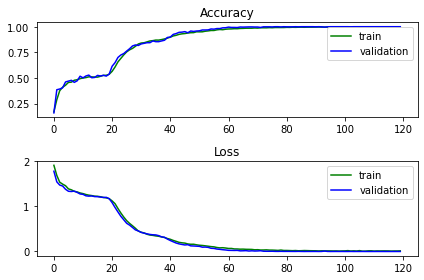

In [49]:
# plot accuracy and loss plot
plt.subplot(211)
plt.title("Accuracy")
plt.plot(history.history["acc"], color="g", label="train")
plt.plot(history.history["val_acc"], color="b", label="validation")
plt.legend(loc="best")

plt.subplot(212)
plt.title("Loss")
plt.plot(history.history["loss"], color="g", label="train")
plt.plot(history.history["val_loss"], color="b", label="validation")
plt.legend(loc="best")

plt.tight_layout()
plt.show()

# labels
ytest = np.argmax(Ytest, axis=1)

# get predictions
Ytest_ = model.predict([Xstest, Xqtest])
ytest_ = np.argmax(Ytest_, axis=1)

In [50]:
NUM_DISPLAY = 30

print("{:18}|{:5}|{}".format("질문", "실제값", "예측값"))
print(39 * "-")

for i in range(NUM_DISPLAY):
    question = " ".join([idx2word[x] for x in Xqtest[i].tolist()])
    label = idx2word[ytest[i]]
    prediction = idx2word[ytest_[i]]
    print("{:20}: {:7} {}".format(question, label, prediction))

질문                |실제값  |예측값
---------------------------------------
은경이는 어디야 ?          : 복도      복도
필웅이는 어디야 ?          : 화장실     화장실
경임이는 어디야 ?          : 부엌      부엌
경임이는 어디야 ?          : 복도      복도
경임이는 어디야 ?          : 부엌      부엌
경임이는 어디야 ?          : 복도      복도
경임이는 어디야 ?          : 정원      정원
수종이는 어디야 ?          : 복도      복도
경임이는 어디야 ?          : 사무실     사무실
수종이는 어디야 ?          : 사무실     사무실
필웅이는 어디야 ?          : 부엌      부엌
필웅이는 어디야 ?          : 정원      정원
수종이는 어디야 ?          : 사무실     사무실
필웅이는 어디야 ?          : 침실      침실
필웅이는 어디야 ?          : 침실      침실
은경이는 어디야 ?          : 부엌      부엌
은경이는 어디야 ?          : 정원      정원
은경이는 어디야 ?          : 부엌      부엌
수종이는 어디야 ?          : 사무실     사무실
은경이는 어디야 ?          : 부엌      부엌
필웅이는 어디야 ?          : 복도      복도
은경이는 어디야 ?          : 사무실     사무실
은경이는 어디야 ?          : 사무실     사무실
경임이는 어디야 ?          : 복도      복도
수종이는 어디야 ?          : 침실      침실
경임이는 어디야 ?          : 침실      침실
필웅이는 어디야 ?          : 침실      침실
수종이는 어디야 ?          : 부엌      부엌
